In [1]:
import pandas as pd
import plotly_express as px
import ipywidgets as widgets
import requests
import folium
import numpy as np
import json
import ipywidgets as ipw
import matplotlib.pyplot as plt
import seaborn as sns

# L'URL de l'API pour donné de compteur 
limit_datacount = 100 # télécharger 100 données mais ne pas saugarder localement 
offset_datacount = 0
dateEtHeure ='2023-12-24T23'
#api avec un filtre "order by" dans l'ordre décroissant de dates dans datacount
api_url_datacount = "https://data.metropole-rouen-normandie.fr/api/explore/v2.1/catalog/datasets/eco-counter-data/records?order_by=date%20DESC&limit=" + str(limit_datacount) +"&offset=" + str(offset_datacount)

#L'URL de l'API pour localisation des sites de comptage
api_url_localisation = "https://data.metropole-rouen-normandie.fr/api/explore/v2.1/catalog/datasets/eco-counter-sites/records?limit=29"

#L'URL de l'API pour télécharger toutes les données 
api_url_export = "https://data.metropole-rouen-normandie.fr/api/explore/v2.1/catalog/datasets/eco-counter-data/exports/json?lang=fr&timezone=Europe%2FBerlin"


# #local_data telecharge depuis serveur
local_data = pd.read_json("local_data.json")

update_data = [] # initialise update_data par une liste

dateEtHeure = local_data.iloc[0]['date'][:-12] # pour avoir la forme de variable dateEtHeure identique que celle declarée dessus

#L'URL de l'API pour la mise à jour de données (where date > dateEtHeure le plus récent indiqué dans local_data, order by date descendant, timezone Europe/Berlin)
api_url_update_data ="https://data.metropole-rouen-normandie.fr/api/explore/v2.1/catalog/datasets/eco-counter-data/records?where=date%3Edate'"+dateEtHeure+"%3A00%3A00%2B01%3A00'&order_by=date%20DESC&limit="+str(limit_datacount)+"&offset="+str(offset_datacount)+"&timezone=Europe%2FBerlin"


# Effectuer une requête GET pour obtenir les données
response_updateData = requests.get(api_url_update_data) # dictionnaire (indice total_count, indice results)
response_localisation = requests.get(api_url_localisation)

if (response_updateData.status_code != 200):
   
    print(f'Échec de la requête HTTP, code de statut {response_updateData.status_code}')

if (response_localisation.status_code != 200):
   
    print(f'Échec de la requête HTTP, code de statut {response_localisation.status_code}')



# Si la requête a réussi (code de statut HTTP 200), vous pouvez accéder aux données
data_localisation = response_localisation.json()

total_count = response_updateData.json()['total_count']

print(total_count)

if (total_count != 0) : # le nombre de données mises à jour 
    while (total_count >= 100) : # data limit is 100
        update_data.extend(requests.get(api_url_update_data).json()['results'])
        total_count -= 100
        offset_datacount +=  100
        api_url_update_data ="https://data.metropole-rouen-normandie.fr/api/explore/v2.1/catalog/datasets/eco-counter-data/records?where=date%3Edate'"+dateEtHeure+"%3A00%3A00%2B01%3A00'&order_by=date%20DESC&limit="+str(limit_datacount)+"&offset="+str(offset_datacount)+"&timezone=Europe%2FBerlin"

    limit_datacount = total_count
    api_url_update_data ="https://data.metropole-rouen-normandie.fr/api/explore/v2.1/catalog/datasets/eco-counter-data/records?where=date%3Edate'"+dateEtHeure+"%3A00%3A00%2B01%3A00'&order_by=date%20DESC&limit="+str(limit_datacount)+"&offset="+str(offset_datacount)+"&timezone=Europe%2FBerlin"
    update_data.extend(requests.get(api_url_update_data).json()['results'])
    list_local_data =local_data.to_dict(orient='records')
    update_data.extend(list_local_data)
    # Utilisez json.dump() pour sauvegarder le dictionnaire dans le fichier JSON

    with open('local_data.json', 'w') as fichier_json:
        json.dump(update_data, fichier_json)

6264


In [10]:
df = pd.read_json('local_data.json')
ids = df['id'].unique()
print(ids)
df.columns

[100037866 300038237 300033014 300027449 300037150 100005525 100007115
 100018293 100048215 100057697 300033642 300035379 100005527 100007116
 100018089 100033302 100056983 100057696 300023463 300028856 300035455
 300033641 100033300 100033301 100005524 100007117 100018294 100019265
 300035391]


Index(['id', 'date', 'counts', 'status', 'name', 'user_type', 'photourl',
       'date_j'],
      dtype='object')

['2024-03-20' '2024-03-19' '2024-03-18' '2024-03-17' '2024-03-16'
 '2024-03-15' '2024-03-14' '2024-03-13' '2024-03-12' '2024-03-11'
 '2024-03-10' '2024-03-09' '2024-03-08' '2024-03-07' '2024-03-06'
 '2024-03-05' '2024-03-04' '2024-03-03' '2024-03-02' '2024-03-01'
 '2024-02-29' '2024-02-28' '2024-02-27' '2024-02-26' '2024-02-25'
 '2024-02-24' '2024-02-23' '2024-02-22' '2024-02-21' '2024-02-20'
 '2024-02-19' '2024-02-18' '2024-02-17' '2024-02-16' '2024-02-15'
 '2024-02-14' '2024-02-13' '2024-02-12' '2024-02-11' '2024-02-10'
 '2024-02-09' '2024-02-08' '2024-02-07' '2024-02-06' '2024-02-05'
 '2024-02-04' '2024-02-03' '2024-02-02' '2024-02-01' '2024-01-31'
 '2024-01-30' '2024-01-29' '2024-01-28' '2024-01-27' '2024-01-26'
 '2024-01-25' '2024-01-24' '2024-01-23' '2024-01-22' '2024-01-21'
 '2024-01-20' '2024-01-19' '2024-01-18' '2024-01-17' '2024-01-16'
 '2024-01-15' '2024-01-14' '2024-01-13' '2024-01-12' '2024-01-11'
 '2024-01-10' '2024-01-09' '2024-01-08' '2024-01-07' '2024-01-06'
 '2024-01-

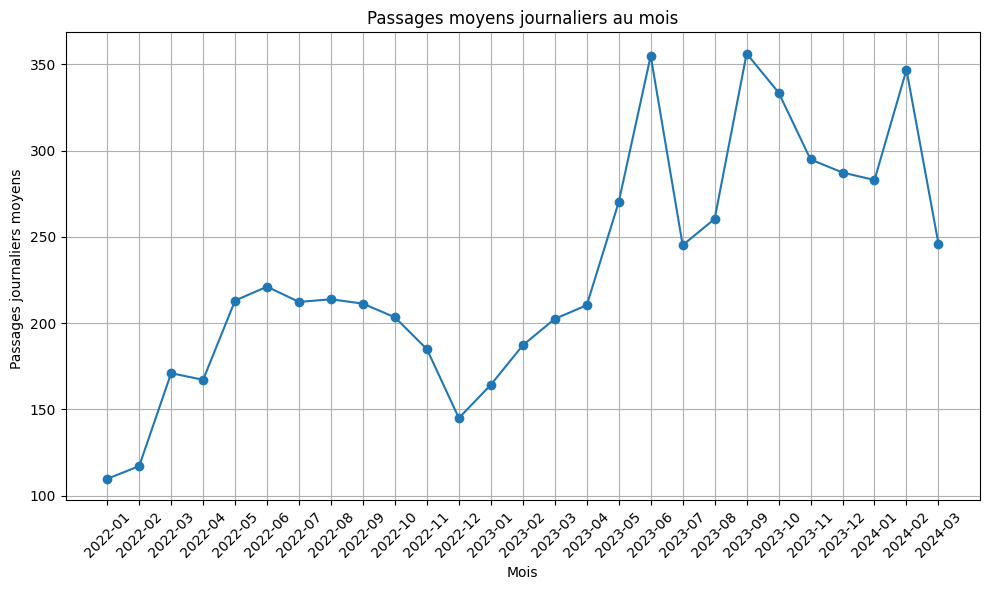

In [11]:
mois = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
an = ['2022', '2023', '2024']
date_jour = df['date_j'].unique()
print(date_jour)
# Convertir en datetime
df['date'] =  pd.to_datetime(df['date'], utc=True) # convertir depuis string en datetime
df['date_j'] = pd.to_datetime(df['date_j']) # convertir depuis string en datetime
df['month_year'] = df['date_j'].dt.to_period('M') # créer une colonne contenant le mois et l'année

# Créer une liste de tous les mois de 2022 à 2024
months = pd.period_range(start=df['month_year'].iloc[-1], end=df['month_year'].iloc[0], freq='M')

# Créer un DataFrame avec une colonne 'mois' contenant tous les mois et une colonne 'mean_count_per_day' initialisée à None
df_result = pd.DataFrame({'mois': months, 'mean_count_per_day': [None] * len(months)})

# Remplir la colonne 'mean_count_per_day' avec les valeurs moyennes correspondantes
for i, month_period in enumerate(months):
    # Calculer la valeur moyenne pour le mois donné
    total_counts = df[df['month_year'] == month_period]['counts'].sum()
    # passages moyennes journaliers par station
    mean_counts_per_day = total_counts / month_period.to_timestamp().days_in_month / len(df['name'].unique())
    # Assigner la valeur moyenne à la ligne correspondante dans le DataFrame résultant
    df_result.at[i, 'mean_count_per_day'] = mean_counts_per_day

# Afficher le résultat
plt.figure(figsize=(10, 6))
df_result['mois_str'] = df_result['mois'].astype(str)
plt.plot(df_result['mois_str'], df_result['mean_count_per_day'], marker='o', linestyle='-')

plt.title('Passages moyens journaliers au mois')
plt.xlabel('Mois')
plt.ylabel('Passages journaliers moyens ')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

           day      hour mean_count_per_day
0       Monday  00:00:00                  1
1      Tuesday  01:00:00                  0
2    Wednesday  02:00:00                  1
3     Thursday  03:00:00                  2
4       Friday  04:00:00                  3
..         ...       ...                ...
163  Wednesday  19:00:00                 13
164   Thursday  20:00:00                  9
165     Friday  21:00:00                  7
166   Saturday  22:00:00                  4
167     Sunday  23:00:00                  3

[168 rows x 3 columns]


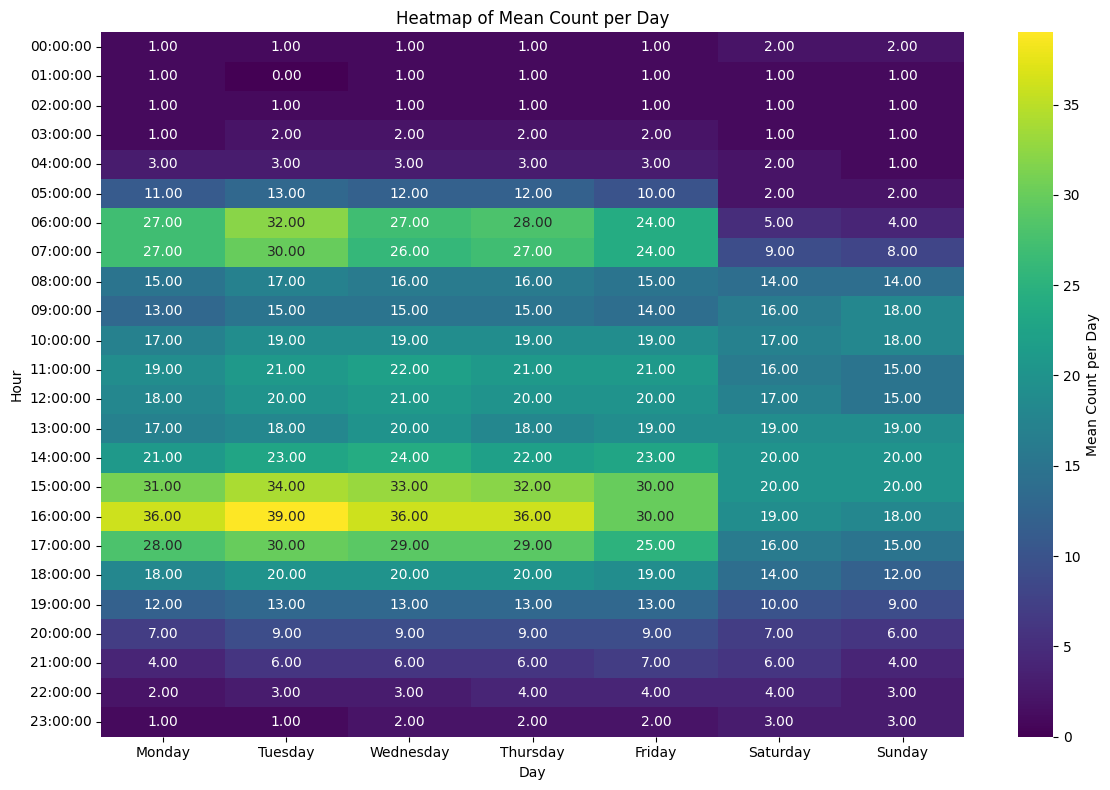

In [12]:
# Créer une liste de tous les heures dans une journée
heures = pd.period_range(start='00:00', end='23:00', freq='h')
heures_only = [str(heure.strftime('%H:%M:%S')) for heure in heures]

# Créer une liste de tous les jours de la semaine
days_in_a_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Créer un DataFrame avec une colonne 'day' contenant les jours, une colonne 'hour' contenant les heures, 
# et une colonne 'mean_count_per_day' initialisée à None
df_result = pd.DataFrame({'day': days_in_a_week * len(heures_only), # 24 heures x 7 jours
                          'hour': heures_only * len(days_in_a_week), 
                          'mean_count_per_day': [None] * len(days_in_a_week) * len(heures_only)})

df['day_name'] = df['date_j'].dt.day_name() # convertir depuis date en day_name (Monday, Tuesday)

# Extraire uniquement l'heure de la colonne 'date' et stocker le résultat dans une nouvelle colonne 'heure' dans df
df['heure'] = df['date'].dt.strftime('%H:%M:%S')

# Remplir la colonne 'mean_count_per_day' de df_result avec les valeurs moyennes appropriées
for hour in heures_only:
    for day_name in days_in_a_week:
        # créer un autre datafame qui contient toutes les données correspondantes au jour et à l'heure donnés
        filtered_data = df[(df['day_name'] == day_name) & (df['heure'] == hour)]
        # Calculer la moyenne des valeurs de la colonne 'counts' pour ces données filtrées
        mean_count = filtered_data['counts'].mean()
        # Assigner la valeur moyenne à la date et heure correspondantes dans le DataFrame résultant
        df_result.loc[(df_result['day'] == day_name) & (df_result['hour'] == hour), 'mean_count_per_day'] = round(mean_count)

print(df_result)

# Convertir les colonnes 'day' et 'hour' en variables catégorielles avec un ordre spécifique
df_result['day'] = pd.Categorical(df_result['day'], categories=days_in_a_week, ordered=True)
df_result['hour'] = pd.Categorical(df_result['hour'], categories=heures_only, ordered=True)
df_result['mean_count_per_day'] = pd.to_numeric(df_result['mean_count_per_day'], errors='coerce')

# Pivoter les données pour avoir les jours comme index, les heures comme colonnes et les valeurs de 'mean_count_per_day' comme valeurs
heatmap_data = df_result.pivot(index='hour', columns='day', values='mean_count_per_day')

# Tracer le heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt=".2f", cbar_kws={'label': 'Mean Count per Day'})
plt.title('Heatmap of Mean Count per Day')
plt.xlabel('Day')
plt.ylabel('Hour')
plt.tight_layout()
plt.show()

  jours_de_semaine moy_journaliere
0           Monday             243
1          Tuesday             272
2        Wednesday             265
3         Thursday             260
4           Friday             247
5         Saturday             179
6           Sunday             168


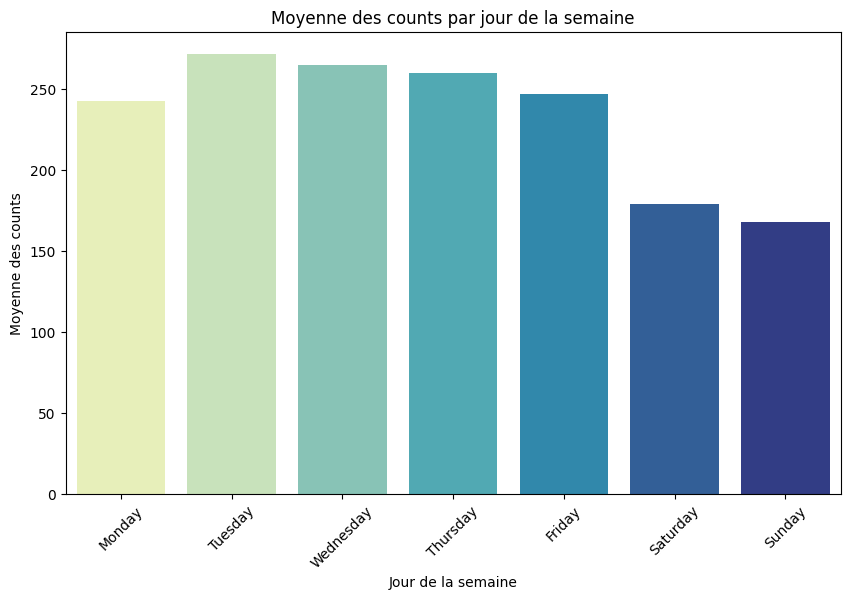

In [13]:
# Créer le DataFrame df_result_moy_journaliere
df_result_moy_journaliere = pd.DataFrame({'jours_de_semaine': days_in_a_week, 'moy_journaliere': [None] * len(days_in_a_week)})

# Pour chaque jour de la semaine
for day_name in days_in_a_week:
    # Filtrer les données pour le jour donné
    filtered_data = df[df['day_name'] == day_name]
    unique_days = len(filtered_data['date_j'].unique()) # enlever les heures et garder que la date
    # Calculer la moyenne des valeurs de la colonne 'counts' pour ces données filtrées
    mean_count = filtered_data['counts'].sum() / unique_days/ len(df['name'].unique())  # somme de tous les passages pour chaque date/ nombre de chaque date/ nombre de stations
    # Assigner la valeur moyenne à la date correspondante dans le DataFrame résultant
    df_result_moy_journaliere.loc[df_result_moy_journaliere['jours_de_semaine'] == day_name, 'moy_journaliere'] = round(mean_count)

print(df_result_moy_journaliere)

# Tracer un histogramme de la moyenne journalière
plt.figure(figsize=(10, 6))
sns.barplot(data=df_result_moy_journaliere, x='jours_de_semaine', y='moy_journaliere', hue='jours_de_semaine', palette='YlGnBu', dodge=False)
plt.title('Moyenne des counts par jour de la semaine')
plt.xlabel('Jour de la semaine')
plt.ylabel('Moyenne des counts')
plt.xticks(rotation=45)  # Rotation des étiquettes d'axe x pour une meilleure lisibilité
plt.show()


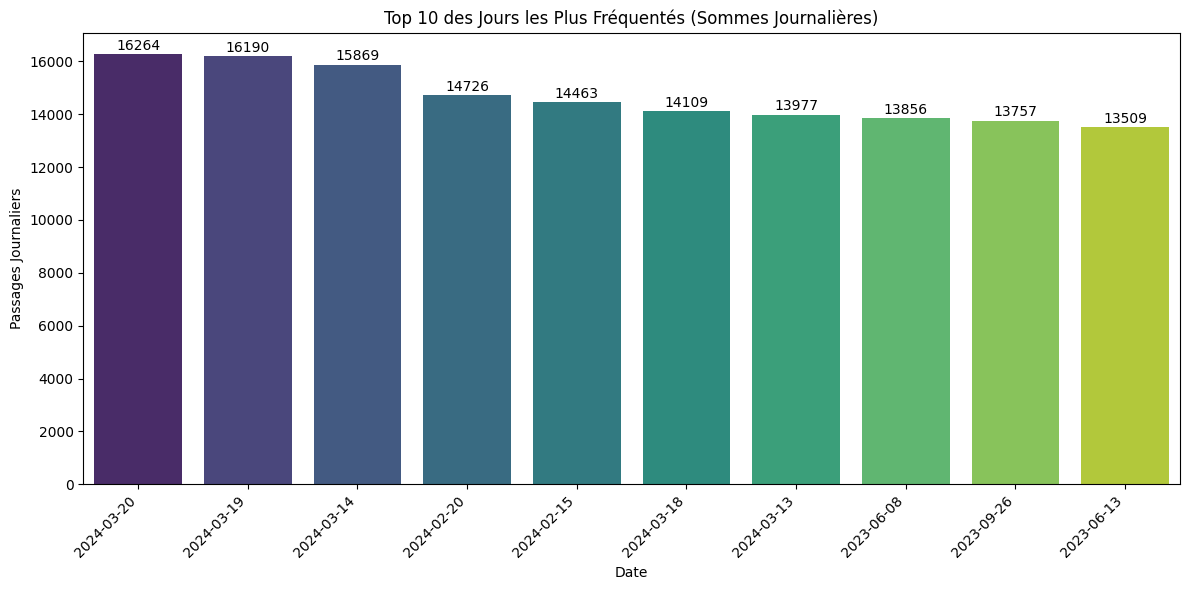

In [14]:
# Grouper par date_j et calculer la somme des passages pour chaque jour
daily_counts = df.groupby('date_j')['counts'].sum().reset_index()

# Trier par ordre décroissant pour obtenir les jours les plus fréquentés en premier
top_10_days = daily_counts.sort_values(by='counts', ascending=False).head(10)

# Tracer l'histogramme
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x='date_j', y='counts', hue='date_j', data=top_10_days, palette='viridis', dodge=False, legend=False)
plt.title('Top 10 des Jours les Plus Fréquentés (Sommes Journalières)')
plt.xlabel('Date')
plt.ylabel('Passages Journaliers')
plt.xticks(rotation=45, ha='right')  # Rotation des étiquettes d'axe x pour une meilleure lisibilité
plt.tight_layout()

# Afficher le nombre de passages sur chaque bar
for idx, value in enumerate(top_10_days['counts']):
    bar_plot.text(idx, value + 50, str(value), ha='center', va='bottom')

plt.show()

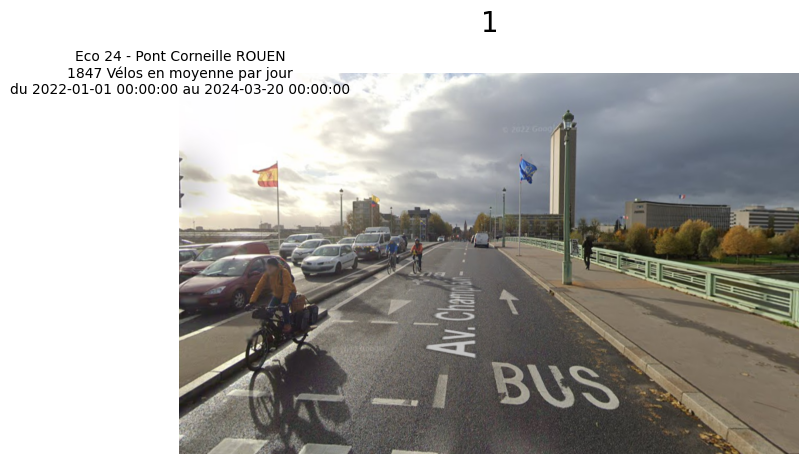

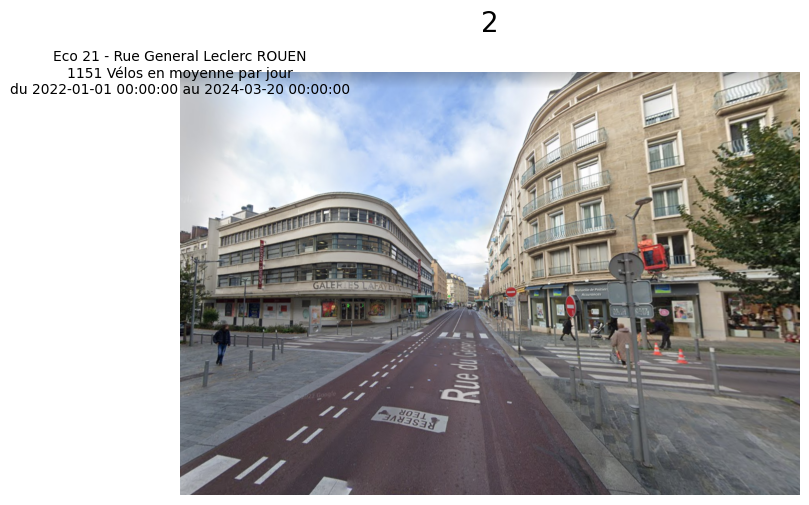

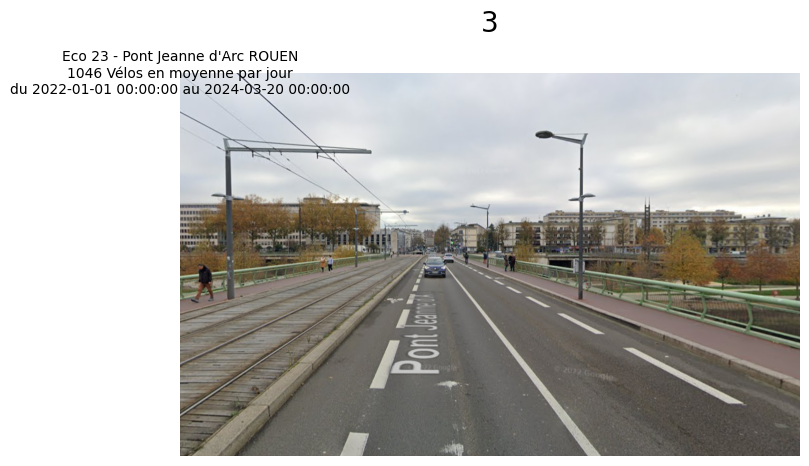

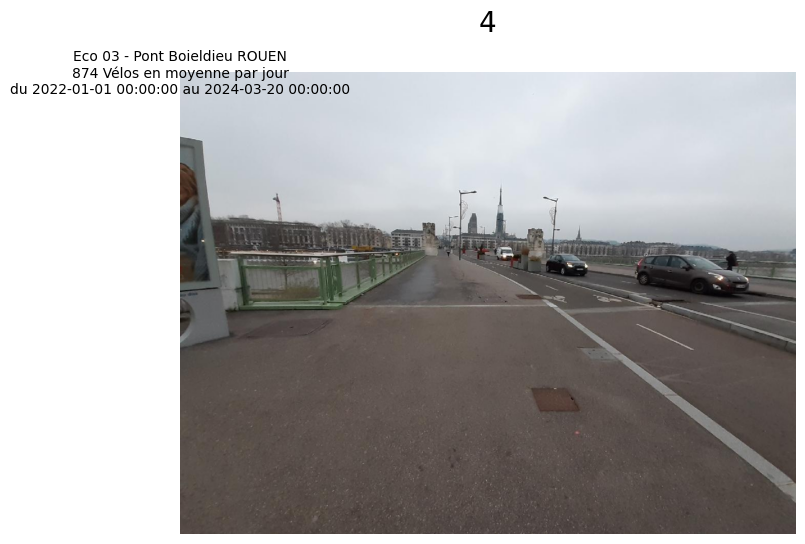

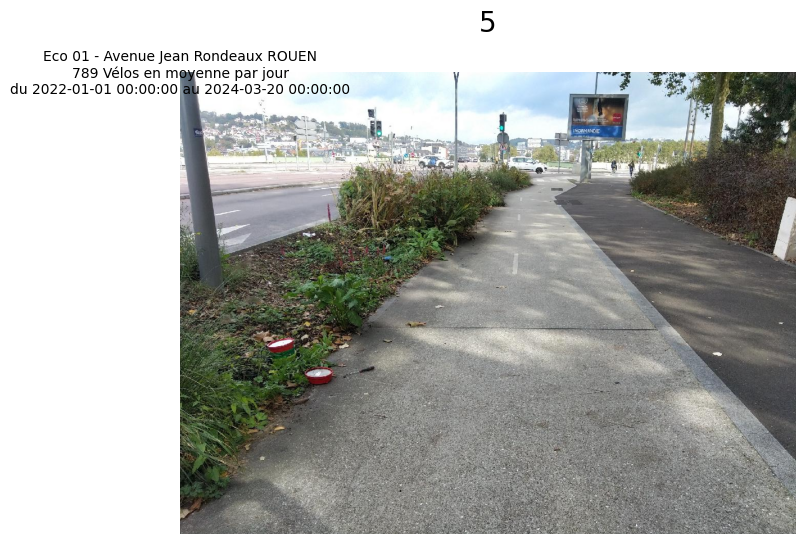

In [15]:
from PIL import Image, ImageDraw
from io import BytesIO
# Calculer le nombre total moyen de passages par jour pour chaque station
station_stats = df.groupby(['id', 'name', 'photourl']).agg(total_passages=('counts', 'sum'), total_days=('date_j', 'nunique')).reset_index()
station_stats['average_passages_per_day'] = station_stats['total_passages'] / station_stats['total_days']

# Classer les stations par le nombre total moyen de passages par jour de manière décroissante
top_stations = station_stats.sort_values(by='average_passages_per_day', ascending=False).head(5)

# Afficher les informations pour les cinq meilleures stations avec les images correspondantes depuis les liens dans 'photourl'
for i, (index, station) in enumerate(top_stations.iterrows(), 1):
    # Charger l'image depuis le lien correspondant à la station
    response = requests.get(station['photourl'])
    img = Image.open(BytesIO(response.content))

    # Afficher le numéro de la station et son image
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.title(f'{i}\n', loc='center', fontsize=20)

    # Afficher les informations de la station
    plt.text(0.5, 0.5, f'{station["name"]}\n'
                        f'{int(station["average_passages_per_day"])} Vélos en moyenne par jour\n'
                        f'du {df["date_j"].min()} au {df["date_j"].max()}',
             ha='center', va='center', fontsize=10)

    # Masquer les axes
    plt.axis('off')

    # Afficher l'image
    plt.show()

In [17]:
df

,id,date,counts,status,name,user_type,photourl,date_j,month_year,day_name,heure
0,100037866,2024-03-20 22:00:00+00:00,4,raw,Eco 17 - Boulevard Gambetta ROUEN,Vélo,https://filer.eco-counter-tools.com/file/29/90...,2024-03-20,2024-03,Wednesday,22:00:00
1,300038237,2024-03-20 22:00:00+00:00,1,raw,Eco 28 - Pont Jaurès ELBEUF,Vélo,https://filer.eco-counter-tools.com/file/19/15...,2024-03-20,2024-03,Wednesday,22:00:00
2,300033014,2024-03-20 22:00:00+00:00,2,raw,Eco 22 - Rte de Paris FRANQUEVILLE,Vélo,https://filer.eco-counter-tools.com/file/f6/3a...,2024-03-20,2024-03,Wednesday,22:00:00
3,300027449,2024-03-20 22:00:00+00:00,0,raw,Eco 20 - Rue Clarin Mustad DUCLAIR,Vélo,https://filer.eco-counter-tools.com/file/a2/5f...,2024-03-20,2024-03,Wednesday,22:00:00
4,300037150,2024-03-20 22:00:00+00:00,13,raw,Eco 00 - Quai du Havre ROUEN,Vélo,https://filer.eco-counter-tools.com/file/3f/78...,2024-03-20,2024-03,Wednesday,22:00:00
...,...,...,...,...,...,...,...,...,...,...,...
413964,100018294,2021-12-31 23:00:00+00:00,0,raw,Eco 12 - Rue de la Foret VAL DE LA HAYE,Vélo,https://filer.eco-counter-tools.com/file/da/73...,2022-01-01,2022-01,Saturday,23:00:00
413965,100019265,2021-12-31 23:00:00+00:00,0,raw,Eco 04 - Zénith GRAND QUEVILLY,Vélo,https://filer.eco-counter-tools.com/file/f1/c9...,2022-01-01,2022-01,Saturday,23:00:00
413966,100007115,2021-12-31 23:00:00+00:00,0,raw,Eco 07 - Sente des Forrieres BOIS GUILLAUME,Vélo,https://filer.eco-counter-tools.com/file/d4/f7...,2022-01-01,2022-01,Saturday,23:00:00
413967,100005525,2021-12-31 23:00:00+00:00,0,raw,Eco 06 - Rue de la Prevotiere BOIS GUILLAUME,Vélo,https://filer.eco-counter-tools.com/file/3f/51...,2022-01-01,2022-01,Saturday,23:00:00


In [21]:
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.strftime('%Y-%m-%d %H:%M:%S')
df['Time'] = df['date']
df['Date'] = pd.to_datetime(df['date_j'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.day_of_week

# Convert 'Time' to datetime if it's not already
df['Time'] = pd.to_datetime(df['Time'])

# Extract the hour
df['Hour'] = df['Time'].dt.hour

In [23]:
import pandas as pd
from dash import Dash, dcc, html, Input, Output, State
import dash_leaflet as dl
from dash_leaflet import CircleMarker
import geopandas as gpd
import requests



# lat1 = 49.4431
# lon1 = 1.0993
# Exemple de GeoJSON (remplacez-le par vos propres données GeoJSON)
geojson_data = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {},
            "geometry": {
                "type": "Point",
                "coordinates": [1.0993, 49.4431]  # Exemple de coordonnées (lon, lat)
            }
        }
    ]
}
app = Dash()
# Récupération des données depuis l'API et création du DataFrame
api_url_localisation = "https://data.metropole-rouen-normandie.fr/api/explore/v2.1/catalog/datasets/eco-counter-sites/records?limit=29"
response_localisation = requests.get(api_url_localisation)

if response_localisation.status_code != 200:
    print(f'Échec de la requête HTTP, code de statut {response_localisation.status_code}')
    data_localisation = None
else:
    data_localisation = response_localisation.json()

data_localisation_df = pd.DataFrame(data_localisation['results'])
# Ajout de la colonne 'Month-Year' à df
df['Month-Year'] = df['Month'].astype(str) + '-' + df['Year'].astype(str)

# Fusion des DataFrames df et data_localisation_df sur la colonne 'name'
df_merged = pd.merge(df, data_localisation_df[['name', 'coordinates']], how='left', on='name')

# Création d'une liste de tous les mois de janvier 2022 à janvier 2024
months = df_merged['Month-Year'].unique()

# Création de la liste de dictionnaires
result_data = []
for mois in months:
    for nom in df_merged['name'].unique():
        filtered_data = df_merged[(df_merged['name'] == nom) & (df_merged['Month-Year'] == mois)]
        sum_count = filtered_data['counts'].sum()
        result_data.append({'mois': mois, 'name': nom, 'volume_month': sum_count})

df_result = pd.DataFrame(result_data)


# Define the default latitude and longitude
lat = data_localisation['results'][5]['coordinates']['lat']
lon = data_localisation['results'][5]['coordinates']['lon']

# Create the layout of the app
app.layout = html.Div([
    html.Div([
        html.Div(['Select Month'], style={'width': '37%', 'display': 'inline-block'}),
        dcc.Dropdown(
            id='month-dropdown',
            options=[{'label': month, 'value': month} for month in df_result['mois'].unique()],
            value=df_result['mois'][0],
            placeholder='Select a month'
        )
    ]),
    html.Div([
        html.H2('Add Shapes to Map an Area of Interest'),
        dl.Map(
            id='leaflet-map',
            style={'width': '100%', 'height': '50vh'},
            center=[lat, lon],
            zoom=10,
            children=[
                dl.TileLayer(),
                dl.FeatureGroup([
                    dl.EditControl(id="edit_control"),
                ]),
                dl.GeoJSON(id='map-geojsons', data=geojson_data)  # Ajout de la couche GeoJSON
            ]
        )
    ])
])

# Define the callback to update the circle radius
@app.callback(
    Output('leaflet-map', 'children'),
    [Input('month-dropdown', 'value')]
   
)
def update_map(selected_time):
    map_children = [
        dl.TileLayer(url="https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png")
    ]
    
    # Si la valeur sélectionnée est nulle, utilisez le premier mois de la liste
    if not selected_time:
        selected_time = df_result['mois'].iloc[0]
    
    max_volume = df_result['volume_month'].max()
    
    for record in data_localisation['results']:
        lon = record['coordinates']['lon']
        lat = record['coordinates']['lat']
      
        filtered_data = df_result[(df_result['mois'] == selected_time) & (df_result['name'] == record['name'])]
        volume = filtered_data['volume_month'].iloc[0] if not filtered_data.empty else 0
        
        scaled_radius = int(volume / max_volume * 50)
        
        circle_marker = dl.CircleMarker(center=(lat, lon), radius=scaled_radius, color="red", fillColor="red")
        map_children.append(circle_marker)
    
    # Ajouter la couche GeoJSON (exemple fictif)
    map_children.append(dl.GeoJSON(data=geojson_data))
    
    return map_children



if __name__ == '__main__':
    app.run_server(debug=True, port=8054)

In [8]:
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.strftime('%Y-%m-%d %H:%M:%S')
df['Time'] = df['date']
df['Date'] = pd.to_datetime(df['date_j'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.day_of_week

# Convert 'Time' to datetime if it's not already
df['Time'] = pd.to_datetime(df['Time'])

# Extract the hour
df['Hour'] = df['Time'].dt.hour


In [9]:
from ipyleaflet import Map, CircleMarker
from IPython.display import display


# Ajout de la colonne 'Month-Year' à df
df['Month-Year'] = df['Month'].astype(str) + '-' + df['Year'].astype(str)

# L'URL de l'API pour localisation des sites de comptage
api_url_localisation = "https://data.metropole-rouen-normandie.fr/api/explore/v2.1/catalog/datasets/eco-counter-sites/records?limit=29"
response_localisation = requests.get(api_url_localisation)

if response_localisation.status_code != 200:
    print(f'Échec de la requête HTTP, code de statut {response_localisation.status_code}')
    data_localisation = None
else:
    data_localisation = response_localisation.json()

# Création d'un DataFrame à partir des données de localisation
data_localisation_df = pd.DataFrame(data_localisation['results'])

# Fusion des DataFrames df et data_localisation_df sur la colonne 'name'
df_merged = pd.merge(df, data_localisation_df[['name', 'coordinates']], how='left', on='name')

# Création d'une liste de tous les mois de janvier 2022 à janvier 2024
months = df_merged['Month-Year'].unique()

# Création de la liste de dictionnaires
result_data = []
for mois in months:
    for nom in df_merged['name'].unique():
        # Filtrage des données pour le mois et le nom
        filtered_data = df_merged[(df_merged['name'] == nom) & (df_merged['Month-Year'] == mois)]
        # Calcul de la somme des valeurs de la colonne 'counts' pour ces données filtrées
        sum_count = filtered_data['counts'].sum()
        # Ajout des données à la liste de dictionnaires
        result_data.append({'mois': mois, 'name': nom, 'volume_month': sum_count})

# Création du DataFrame à partir de la liste de dictionnaires
df_result = pd.DataFrame(result_data)

def update_time(time):
    if data_localisation:
        map_center = [data_localisation['results'][0]['coordinates']['lat'], data_localisation['results'][0]['coordinates']['lon']]
        m = Map(center=map_center, zoom=10)
        
        if time in df_result['mois'].unique():
            max_volume = df_result['volume_month'].max()
            
            for record in data_localisation['results']:
                lon = record['coordinates']['lon']
                lat = record['coordinates']['lat']
                
                # Filtrage des données en fonction du temps
                filtered_data = df_result[(df_result['mois'] == time) & (df_result['name'] == record['name'])]
                volume = filtered_data['volume_month'].iloc[0] if not filtered_data.empty else 0
                
                # Calcul du rayon proportionnel au volume maximal
                scaled_radius = int(volume / max_volume * 50)  # 10 est le rayon maximal souhaité
                
                circle_marker = CircleMarker(location=(lat, lon), radius=scaled_radius, color="red", fill_color="red")
                m.add_layer(circle_marker)
        
        display(m)

# Créer un slider interactif pour sélectionner une plage de dates
dates = [(date.month, date.year) for date in pd.date_range(start='2022-04-01', end='2024-02-01', freq='M')]
date_strings = [f"{month}-{year}" for month, year in dates]

time_slider = widgets.SelectionSlider(options=date_strings, description='Time Range:', layout={'width': '500px'})

# Mettre à jour la carte en fonction de la valeur du curseur
widgets.interact(update_time, time=time_slider)


interactive(children=(SelectionSlider(description='Time Range:', layout=Layout(width='500px'), options=('4-202…

<function __main__.update_time(time)>

In [10]:
def plot(name):
    data = df.loc[df['name']==name,['Time','Date','counts','name']]
    return px.line(x=data['Time'],y=data['counts'],title=name,height=800)

widgets.interact(plot,name=df['name'].unique())

Figure({
    'data': [{'hovertemplate': 'x=%{x}<br>y=%{y}<extra></extra>',
              'legendgroup': '',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '',
              'showlegend': False,
              'type': 'scattergl',
              'x': array([datetime.datetime(2024, 3, 9, 22, 0),
                          datetime.datetime(2024, 3, 9, 21, 0),
                          datetime.datetime(2024, 3, 9, 20, 0), ...,
                          datetime.datetime(2024, 1, 10, 1, 0),
                          datetime.datetime(2024, 1, 10, 0, 0),
                          datetime.datetime(2024, 1, 9, 23, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([1, 1, 0, ..., 0, 0, 1], dtype=int64),
              'yaxis': 'y'}],
    'layout': {'height': 800,
               'legend': {'tracegroupgap': 0},
               'template': '...',
               'title': {'text': 'Eco 28 - Pont Jaurès ELBEUF'},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'x'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'y'}}}
})

interactive(children=(Dropdown(description='name', options=('Eco 28 - Pont Jaurès ELBEUF', 'Eco 21 - Rue Gener…

<function __main__.plot(name)>

In [11]:
def plot_comptage_jour(name):
    data = df.loc[df['name']==name,['Date','counts']]
    data = data.groupby('Date').sum()
    data = data.reset_index()
    return px.line(x=data['Date'],y=data['counts'],title=name,height=500)

widgets.interact(plot_comptage_jour,name=df['name'].unique())

Figure({
    'data': [{'hovertemplate': 'x=%{x}<br>y=%{y}<extra></extra>',
              'legendgroup': '',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': array([datetime.datetime(2024, 1, 10, 0, 0),
                          datetime.datetime(2024, 1, 11, 0, 0),
                          datetime.datetime(2024, 1, 12, 0, 0),
                          datetime.datetime(2024, 1, 13, 0, 0),
                          datetime.datetime(2024, 1, 14, 0, 0),
                          datetime.datetime(2024, 1, 15, 0, 0),
                          datetime.datetime(2024, 1, 16, 0, 0),
                          datetime.datetime(2024, 1, 17, 0, 0),
                          datetime.datetime(2024, 1, 18, 0, 0),
                          datetime.datetime(2024, 1, 19, 0, 0),
                          datetime.datetime(2024, 1, 20, 0, 0),
                          datetime.datetime(2024, 1, 21, 0, 0),
                          datetime.datetime(2024, 1, 22, 0, 0),
                          datetime.datetime(2024, 1, 23, 0, 0),
                          datetime.datetime(2024, 1, 24, 0, 0),
                          datetime.datetime(2024, 1, 25, 0, 0),
                          datetime.datetime(2024, 1, 26, 0, 0),
                          datetime.datetime(2024, 1, 27, 0, 0),
                          datetime.datetime(2024, 1, 28, 0, 0),
                          datetime.datetime(2024, 1, 29, 0, 0),
                          datetime.datetime(2024, 1, 30, 0, 0),
                          datetime.datetime(2024, 1, 31, 0, 0),
                          datetime.datetime(2024, 2, 1, 0, 0),
                          datetime.datetime(2024, 2, 2, 0, 0),
                          datetime.datetime(2024, 2, 3, 0, 0),
                          datetime.datetime(2024, 2, 4, 0, 0),
                          datetime.datetime(2024, 2, 5, 0, 0),
                          datetime.datetime(2024, 2, 6, 0, 0),
                          datetime.datetime(2024, 2, 7, 0, 0),
                          datetime.datetime(2024, 2, 8, 0, 0),
                          datetime.datetime(2024, 2, 9, 0, 0),
                          datetime.datetime(2024, 2, 10, 0, 0),
                          datetime.datetime(2024, 2, 11, 0, 0),
                          datetime.datetime(2024, 2, 12, 0, 0),
                          datetime.datetime(2024, 2, 13, 0, 0),
                          datetime.datetime(2024, 2, 14, 0, 0),
                          datetime.datetime(2024, 2, 15, 0, 0),
                          datetime.datetime(2024, 2, 16, 0, 0),
                          datetime.datetime(2024, 2, 17, 0, 0),
                          datetime.datetime(2024, 2, 18, 0, 0),
                          datetime.datetime(2024, 2, 19, 0, 0),
                          datetime.datetime(2024, 2, 20, 0, 0),
                          datetime.datetime(2024, 2, 21, 0, 0),
                          datetime.datetime(2024, 2, 22, 0, 0),
                          datetime.datetime(2024, 2, 23, 0, 0),
                          datetime.datetime(2024, 2, 24, 0, 0),
                          datetime.datetime(2024, 2, 25, 0, 0),
                          datetime.datetime(2024, 2, 26, 0, 0),
                          datetime.datetime(2024, 2, 27, 0, 0),
                          datetime.datetime(2024, 2, 28, 0, 0),
                          datetime.datetime(2024, 2, 29, 0, 0),
                          datetime.datetime(2024, 3, 1, 0, 0),
                          datetime.datetime(2024, 3, 2, 0, 0),
                          datetime.datetime(2024, 3, 3, 0, 0),
                          datetime.datetime(2024, 3, 4, 0, 0),
                          datetime.datetime(2024, 3, 5, 0, 0),
                          datetime.datetime(2024, 3, 6, 

interactive(children=(Dropdown(description='name', options=('Eco 28 - Pont Jaurès ELBEUF', 'Eco 21 - Rue Gener…

<function __main__.plot_comptage_jour(name)>

In [12]:
def plot_comptage_jour_de_la_semaine(name):
    data = df.loc[df['name']==name,['DayOfWeek','counts']]
    data = data.groupby('DayOfWeek').mean()
    data = data.reset_index()
    return px.bar(x=data['DayOfWeek'],y=data['counts'],title=name,height=500)

widgets.interact(plot_comptage_jour_de_la_semaine,name=df['name'].unique())

Figure({
    'data': [{'alignmentgroup': 'True',
              'hovertemplate': 'x=%{x}<br>y=%{y}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': '',
              'offsetgroup': '',
              'orientation': 'v',
              'showlegend': False,
              'textposition': 'auto',
              'type': 'bar',
              'x': array([0, 1, 2, 3, 4, 5, 6]),
              'xaxis': 'x',
              'y': array([2.25520833, 2.61979167, 2.00462963, 2.27314815, 2.12037037, 1.23611111,
                          1.125     ]),
              'yaxis': 'y'}],
    'layout': {'barmode': 'relative',
               'height': 500,
               'legend': {'tracegroupgap': 0},
               'template': '...',
               'title': {'text': 'Eco 28 - Pont Jaurès ELBEUF'},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'x'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'y'}}}
})

interactive(children=(Dropdown(description='name', options=('Eco 28 - Pont Jaurès ELBEUF', 'Eco 21 - Rue Gener…

<function __main__.plot_comptage_jour_de_la_semaine(name)>

In [13]:
def plot_moyenne_horaire(name):
    data = df.loc[df['name']==name,['Hour','counts']]
    data = data.groupby('Hour').mean()
    data = data.reset_index()
    return px.bar(x=data['Hour'],y=data['counts'],title=name,height=500)

widgets.interact(plot_moyenne_horaire,name=df['name'].unique())

Figure({
    'data': [{'alignmentgroup': 'True',
              'hovertemplate': 'x=%{x}<br>y=%{y}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': '',
              'offsetgroup': '',
              'orientation': 'v',
              'showlegend': False,
              'textposition': 'auto',
              'type': 'bar',
              'x': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
                          18, 19, 20, 21, 22, 23]),
              'xaxis': 'x',
              'y': array([0.06666667, 0.06666667, 0.03333333, 1.15      , 0.8       , 1.36666667,
                          3.93333333, 2.93333333, 2.21666667, 2.33333333, 2.1       , 2.65      ,
                          3.28333333, 2.75      , 3.55      , 3.51666667, 5.2       , 2.75      ,
                          1.85      , 1.48333333, 1.21666667, 0.83333333, 0.25      , 0.35      ]),
              'yaxis': 'y'}],
    'layout': {'barmode': 'relative',
               'height': 500,
               'legend': {'tracegroupgap': 0},
               'template': '...',
               'title': {'text': 'Eco 28 - Pont Jaurès ELBEUF'},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'x'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'y'}}}
})

interactive(children=(Dropdown(description='name', options=('Eco 28 - Pont Jaurès ELBEUF', 'Eco 21 - Rue Gener…

<function __main__.plot_moyenne_horaire(name)>

In [14]:
def plot_volume_annuel(name):
    data = df.loc[df['name']==name,['Year','counts']]
    data = data.groupby('Year').sum()
    data = data.reset_index()
    return px.bar(x=data['Year'],y=data['counts'],title=name,height=500)

widgets.interact(plot_volume_annuel,name=df['name'].unique())

Figure({
    'data': [{'alignmentgroup': 'True',
              'hovertemplate': 'x=%{x}<br>y=%{y}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': '',
              'offsetgroup': '',
              'orientation': 'v',
              'showlegend': False,
              'textposition': 'auto',
              'type': 'bar',
              'x': array([2024]),
              'xaxis': 'x',
              'y': array([2801], dtype=int64),
              'yaxis': 'y'}],
    'layout': {'barmode': 'relative',
               'height': 500,
               'legend': {'tracegroupgap': 0},
               'template': '...',
               'title': {'text': 'Eco 28 - Pont Jaurès ELBEUF'},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'x'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'y'}}}
})

interactive(children=(Dropdown(description='name', options=('Eco 28 - Pont Jaurès ELBEUF', 'Eco 21 - Rue Gener…

<function __main__.plot_volume_annuel(name)>

In [15]:
def plot_volume_mensuel(name):
    data = df.loc[df['name']==name,['Month','Year','counts']]
    data = data.groupby(['Year','Month']).sum()
    data = data.reset_index()
    data['Month-Year'] = data['Month'].astype(str)+'-'+data['Year'].astype(str)
    return px.bar(x=data['Month-Year'],y=data['counts'],title=name,height=500)

widgets.interact(plot_volume_mensuel,name=df['name'].unique())

Figure({
    'data': [{'alignmentgroup': 'True',
              'hovertemplate': 'x=%{x}<br>y=%{y}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': '',
              'offsetgroup': '',
              'orientation': 'v',
              'showlegend': False,
              'textposition': 'auto',
              'type': 'bar',
              'x': array(['1-2024', '2-2024', '3-2024'], dtype=object),
              'xaxis': 'x',
              'y': array([ 913, 1453,  435], dtype=int64),
              'yaxis': 'y'}],
    'layout': {'barmode': 'relative',
               'height': 500,
               'legend': {'tracegroupgap': 0},
               'template': '...',
               'title': {'text': 'Eco 28 - Pont Jaurès ELBEUF'},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'x'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'y'}}}
})

interactive(children=(Dropdown(description='name', options=('Eco 28 - Pont Jaurès ELBEUF', 'Eco 21 - Rue Gener…

<function __main__.plot_volume_mensuel(name)>

In [16]:
def multiplot(name):
    for f in plot(name),plot_comptage_jour(name),plot_comptage_jour_de_la_semaine(name),plot_moyenne_horaire(name),plot_volume_annuel(name),plot_volume_mensuel(name):
        f.show()

widgets.interact(multiplot,name=df['name'].unique())

interactive(children=(Dropdown(description='name', options=('Eco 28 - Pont Jaurès ELBEUF', 'Eco 21 - Rue Gener…

<function __main__.multiplot(name)>